Classifier 0 (0):
	Weights: [ 1.91   3.74  -4.665 -2.25 ]
	Bias:    0.8500

Classifier 1 (1):
	Weights: [ 1.9    0.525 -2.195 -2.72 ]
	Bias:    3.7500

Classifier 2 (2):
	Weights: [-3.81  -4.265  6.86   4.97 ]
	Bias:    -4.6000



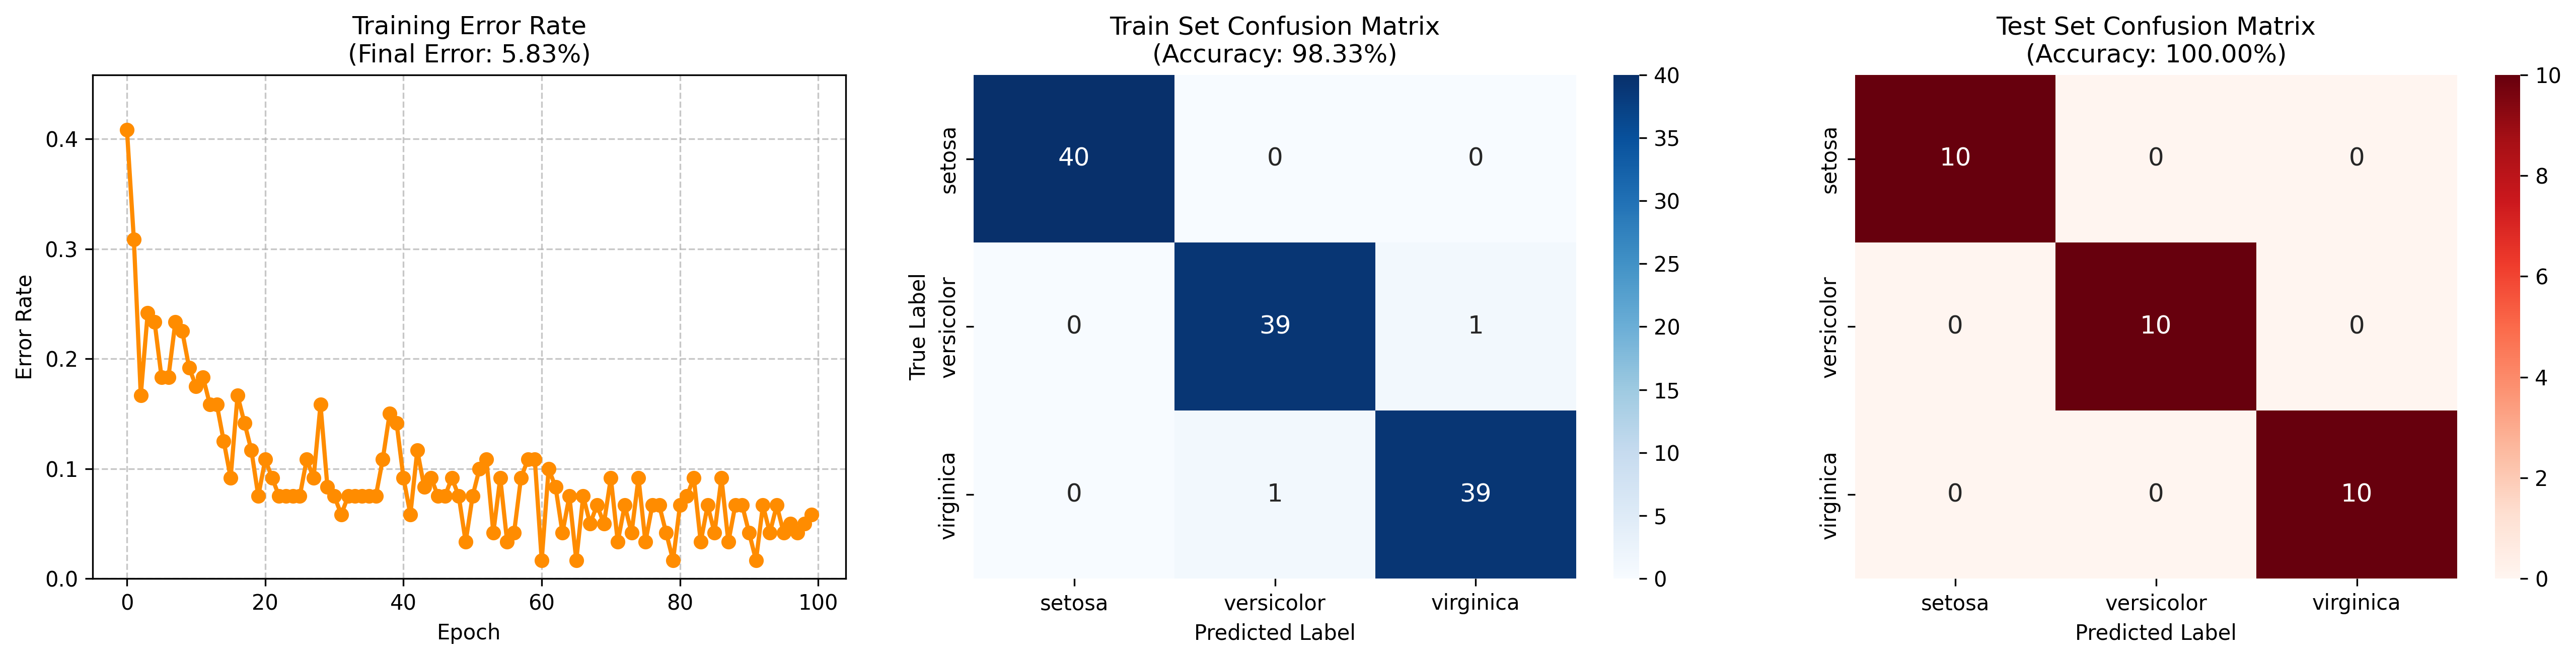

In [2]:
# ==================== 1. 导入库 ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# ==================== 2. 感知机模型类 ====================
class Perceptron:
    # 初始化多类别感知机
    def __init__(self, n_classes, learning_rate=0.1, n_iters=100):
        self.n_classes = n_classes # 类别数量（在IRIS中为3类）
        self.lr = learning_rate    # 学习率，控制参数更新幅度
        self.n_iters = n_iters     # 最大训练迭代次数
        self.classifiers = []    # 存储每个类别的分类器参数
        self.class_labels = None # 存储原始类别标签
        self.loss_history = []   # 记录训练过程中的错误率变化

    #初始化每个二分类器的权重和偏置
    def _init_classifiers(self, n_features):
        self.classifiers = [
            {'weights': np.zeros(n_features), 'bias': 0} 
            for _ in range(self.n_classes)
        ]

    # 多类别投票决策
    def _vote(self, X):
        decisions = np.zeros((self.n_classes, X.shape[0]))
        for i, clf in enumerate(self.classifiers):
            # 计算每个分类器的得分：w_i·x_i + b
            scores = np.dot(X, clf['weights']) + clf['bias']
            decisions[i] = scores
        return np.argmax(decisions, axis=0)  # 取最高得分对应的类别

    # 训练模型
    def fit(self, X, y):
        self.class_labels = np.unique(y)  # 获取唯一类别标签
        n_samples, n_features = X.shape
        self._init_classifiers(n_features)
        
        # 将标签转换为索引形式（0,1,2等）
        y_idx = np.array([np.where(self.class_labels == label)[0][0] for label in y])

        # 迭代训练过程
        for epoch in range(self.n_iters):
            errors = 0
            for sample, true_label in zip(X, y_idx):
                current_preds = self._vote(sample.reshape(1, -1))[0]  # 当前样本预测
                
                if current_preds != true_label:  # 预测错误时更新参数
                    errors += 1
                    # 正更新真实类别分类器
                    self._update_classifier(true_label, sample, 1)
                    # 负更新错误预测类别分类器
                    self._update_classifier(current_preds, sample, -1)
            
            # 计算并记录本次迭代的错误率
            epoch_loss = errors / n_samples
            self.loss_history.append(epoch_loss)
            
            if errors == 0:  # 提前终止条件
                break

    # 更新指定分类器参数
    def _update_classifier(self, classifier_idx, x, direction):
        delta = direction * self.lr
        self.classifiers[classifier_idx]['weights'] += delta * x
        self.classifiers[classifier_idx]['bias'] += delta

    # 预测样本类别
    def predict(self, X):
        return self.class_labels[self._vote(X)]
    
    # 打印所有分类器参数
    def print_weights(self):
        for i, clf in enumerate(self.classifiers):
            print(f"Classifier {i} ({self.class_labels[i]}):")
            print(f"\tWeights: {clf['weights'].round(4)}")
            print(f"\tBias:    {clf['bias']:.4f}\n")

# ==================== 3. 数据准备 ====================
# 加载Iris数据集
df = pd.read_csv("data/iris.csv", index_col=0)  # 假设CSV文件包含标准Iris数据

# 特征和标签提取
X = df[['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']].values
y = df['Species'].values

# 标签编码（将字符串标签转为0,1,2）
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 编码后形式如：0=setosa, 1=versicolor, 2=virginica

# 分层划分训练测试集（保持类别分布）
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2,     # 测试集比例20%
    stratify=y_encoded, # 保持类别比例
    random_state=42    # 随机种子保证可复现性
)

# ==================== 4. 模型训练 ====================
vp = Perceptron(
    n_classes=3, 
    learning_rate=0.05,  # 调参点：影响收敛速度和精度
    n_iters=100          # 调参点：控制训练时长
)
vp.fit(X_train, y_train)  # 执行训练

# ==================== 5. 结果输出与可视化 ====================
# 输出模型参数
vp.print_weights()

# 创建可视化画布
plt.figure(figsize=(18, 5), dpi=300)  # 设置画布尺寸和分辨率

# ---- 子图1：训练误差曲线 ----
plt.subplot(1, 3, 1)
plt.plot(vp.loss_history, color='darkorange', lw=2, marker='o', markersize=6)
plt.title('Training Error Rate\n(Final Error: {:.2%})'.format(vp.loss_history[-1]))
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, max(vp.loss_history)+0.05)  # 设置y轴范围

# ---- 子图2：训练集混淆矩阵 ----
plt.subplot(1, 3, 2)
train_preds = vp.predict(X_train)
train_conf_mat = confusion_matrix(le.inverse_transform(y_train), 
                                 le.inverse_transform(train_preds),
                                 labels=le.classes_)
sns.heatmap(train_conf_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=le.classes_, 
           yticklabels=le.classes_,
           annot_kws={'size':12})
plt.title('Train Set Confusion Matrix\n(Accuracy: {:.2%})'.format(
    np.mean(train_preds == y_train)))
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)

# ---- 子图3：测试集混淆矩阵 ----
plt.subplot(1, 3, 3)
test_preds = vp.predict(X_test)
test_conf_mat = confusion_matrix(le.inverse_transform(y_test), 
                                le.inverse_transform(test_preds),
                                labels=le.classes_)
sns.heatmap(test_conf_mat, annot=True, fmt='d', cmap='Reds',
           xticklabels=le.classes_,
           yticklabels=le.classes_,
           annot_kws={'size':12})
plt.title('Test Set Confusion Matrix\n(Accuracy: {:.2%})'.format(
    np.mean(test_preds == y_test)))
plt.xlabel('Predicted Label', fontsize=10)

plt.tight_layout(pad=3.0)  # 调整子图间距
plt.show()
